In [365]:
import pandas as pd
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,Flatten,MaxPooling2D,Dropout,BatchNormalization, AveragePooling2D, Activation
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from keras import regularizers
from keras.preprocessing.image import ImageDataGenerator
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sn
from sklearn.metrics import roc_curve, auc
import os
import argparse
import cv2

## Importing data

In [2]:
df = pd.read_csv("data/fer2013.csv")

In [3]:
df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [4]:
df.Usage.unique()

array(['Training', 'PublicTest', 'PrivateTest'], dtype=object)

In [5]:
df.Usage.value_counts()

Training       28709
PublicTest      3589
PrivateTest     3589
Name: Usage, dtype: int64

In [6]:
emotions_dict = {0:"Angry", 1:"Disgust", 2: "Fear", 3: "Happy", 4: "Sad", 5:"Surprise", 6:"Neutral"}
#0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral

In [7]:
# Combining PublicTest and PrivateTest to the whole testing set
df_training = df[df["Usage"] == "Training"]
df_validation = df[df["Usage"] == "PublicTest"]
df_testing = df[df["Usage"] == "PrivateTest"]

In [8]:
# Save training set and testing set as csv file for the purpose of futher use
# Uncomment commands below if you need to save these files
df_training.to_csv("data/train.csv", index = False)
df_validation.to_csv("data/test.csv", index = False)
df_testing.to_csv("data/validation.csv", index = False)

In [145]:
# def get_inputs_labels(file_path):
#     df = pd.read_csv(file_path)
#     inputs = [np.array(df["pixels"][i].split(" ")).astype(int) for i in range(df.shape[0])]
#     labels = [df["emotion"][i] for i in range(df.shape[0])]
#     assert len(inputs) == len(labels), "inputs and labels should have the same length."
#     return inputs, labels

In [169]:
# create inputs and labels for the training set
def get_inputs_labels(file_path):
    df = pd.read_csv(file_path)
    inputs = [np.array(df["pixels"][i].split(" ")).astype(int) for i in range(df.shape[0])]
    labels = [df["emotion"][i] for i in range(df.shape[0])]
    assert len(inputs) == len(labels), "inputs and labels should have the same length."
    return np.array(inputs), np.array(labels)

In [10]:
# def training_testing_prep(training_file_path, validation_file_path, testing_file_path):
#     image_size = 48
#     training_inputs, training_labels = get_inputs_labels(training_file_path)
#     validation_inputs, validation_labels = get_inputs_labels(validation_file_path)
#     testing_inputs, testing_labels = get_inputs_labels(testing_file_path)
    
#     training_inputs = training_inputs.reshape(training_inputs.shape[0], image_size, image_size, 1)
#     validation_inputs = validation_inputs.reshape(validation_inputs.shape[0], image_size, image_size, 1)
#     testing_inputs = testing_inputs.reshape(testing_inputs.shape[0], image_size, image_size, 1)
    
#     training_labels = tf.one_hot(training_labels, 7, dtype=tf.float32)
#     validation_labels = tf.one_hot(validation_labels, 7, dtype=tf.float32)
#     testing_labels = tf.one_hot(testing_labels, 7, dtype=tf.float32)
    
#     return training_inputs, training_labels, validation_inputs, validation_labels, testing_inputs, testing_labels

In [288]:
# Data Augmentation and Preprocessing
def training_testing_prep(training_file_path, validation_file_path, testing_file_path):
    image_size = 48
    training_inputs1, training_labels = get_inputs_labels(training_file_path)
    validation_inputs1, validation_labels = get_inputs_labels(validation_file_path)
    testing_inputs1, testing_labels = get_inputs_labels(testing_file_path)
    
    training_inputs = training_inputs1.reshape(training_inputs1.shape[0], image_size, image_size, 1)
    ver_lst = [[]]
    for i in range(len(training_inputs)):
        flip = [list(np.concatenate(training_inputs[i,::-1,:,0]))]
        ver_lst += flip
    ver_ary = np.array(ver_lst[1:])
    training_inputs1 = np.concatenate((training_inputs1, ver_ary), axis = 0)
    training_inputs = training_inputs1.reshape(training_inputs1.shape[0], image_size, image_size, 1)

    
    validation_inputs = validation_inputs1.reshape(validation_inputs1.shape[0], image_size, image_size, 1)
    ver_lst = [[]]
    for i in range(len(validation_inputs)):
        flip = [list(np.concatenate(validation_inputs[i,::-1,:,0]))]
        ver_lst += flip
    ver_ary = np.array(ver_lst[1:])
    validation_inputs1 = np.concatenate((validation_inputs1, ver_ary), axis = 0)
    validation_inputs = validation_inputs1.reshape(validation_inputs1.shape[0], image_size, image_size, 1)
    
    
    testing_inputs = testing_inputs1.reshape(testing_inputs1.shape[0], image_size, image_size, 1)
    ver_lst = [[]]
    for i in range(len(testing_inputs)):
        flip = [list(np.concatenate(testing_inputs[i,::-1,:,0]))]
        ver_lst += flip
    ver_ary = np.array(ver_lst[1:])
    testing_inputs1 = np.concatenate((testing_inputs1, ver_ary), axis = 0)
    testing_inputs = testing_inputs1.reshape(testing_inputs1.shape[0], image_size, image_size, 1)
    
    training_labels = tf.one_hot(training_labels, 7, dtype=tf.float32)
    training_labels = tf.convert_to_tensor(np.concatenate((training_labels, training_labels), axis = 0), dtype=tf.float32)
    
    validation_labels = tf.one_hot(validation_labels, 7, dtype=tf.float32)
    validation_labels = tf.convert_to_tensor(np.concatenate((validation_labels, validation_labels), axis = 0), dtype=tf.float32)
    
    testing_labels = tf.one_hot(testing_labels, 7, dtype=tf.float32)
    testing_labels = tf.convert_to_tensor(np.concatenate((testing_labels, testing_labels), axis = 0), dtype=tf.float32)
    
    return training_inputs, training_labels, validation_inputs, validation_labels, testing_inputs, testing_labels

In [289]:
training_inputs, training_labels, validation_inputs, validation_labels, testing_inputs, testing_label = training_testing_prep("data/train.csv", "data/validation.csv", "data/test.csv")

In [12]:
# for ix in range(10):
#     plt.figure(ix)
#     need_pixel = []
#     for j in range(48):
#         need_pixel.append([training_inputs[ix][j][i][0] for i in range(48)])
#     plt.imshow(need_pixel, interpolation='none', cmap='gray')
#     plt.text(80, 30, emotions_dict[list(training_labels[ix].numpy()).index(1.0)], ha = "center")
#     plt.show()

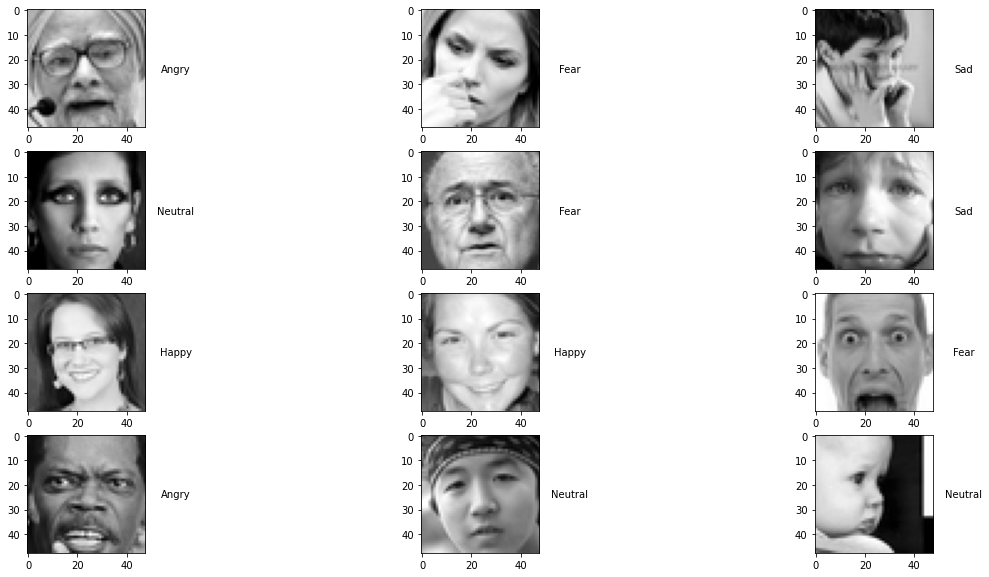

In [301]:
plt.figure(0, figsize=(20,10))
for i in range(1, 13):
    plt.subplot(4,3,i)
    plt.imshow(training_inputs[i, :, :, 0], cmap="gray")
    plt.text(60, 25, emotions_dict[list(training_labels[i].numpy()).index(1.0)], ha = "center")

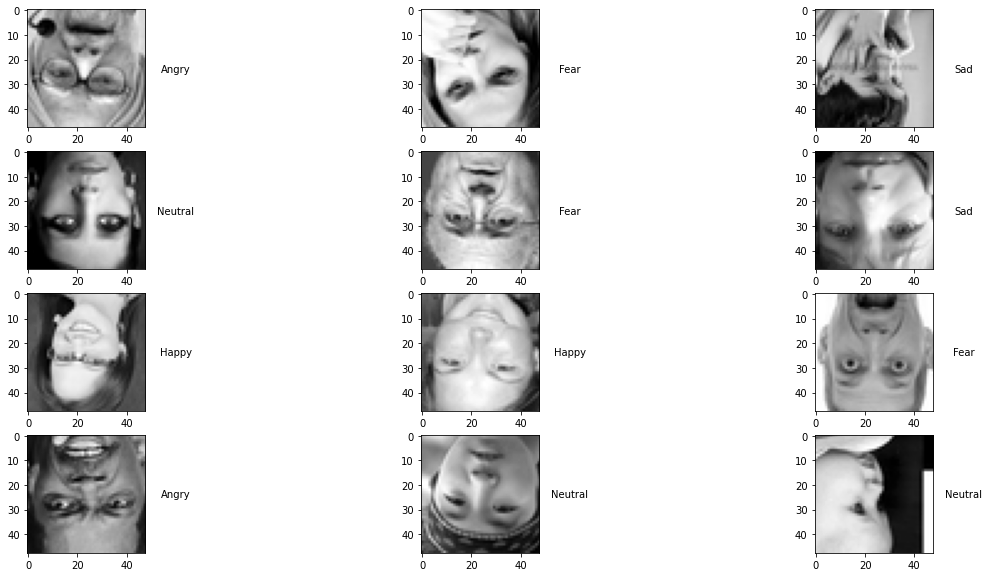

In [304]:
plt.figure(0, figsize=(20,10))
for i in range(1, 13):
    plt.subplot(4,3,i)
    plt.imshow(training_inputs[28709 + i, :, :, 0], cmap="gray")
    plt.text(60, 25, emotions_dict[list(training_labels[28709 + i].numpy()).index(1.0)], ha = "center")

#### Deep Learning: CNN Model

In [305]:
model = Sequential()

model.add(Conv2D(64, kernel_size=(5, 5), padding = "same", activation='relu', input_shape=(48,48,1)))
model.add(Conv2D(64, kernel_size=(5, 5), padding = "same", activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size=(5, 5), padding = "same", activation='relu'))
model.add(BatchNormalization())
model.add(Activation('relu'))
#model.add(MaxPooling2D(pool_size=(3, 3)))
# model.add(Conv2D(64, kernel_size=(3, 3), padding = "same", activation='relu'))
# model.add(BatchNormalization())
# model.add(Activation('relu'))
model.add(AveragePooling2D(pool_size=(2, 2), strides = (3, 3)))
model.add(Dropout(0.4))

model.add(Conv2D(256, kernel_size=(4, 4), padding = "same", activation='relu'))
model.add(Conv2D(256, kernel_size=(4, 4), padding = "same", activation='relu'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))


model.add(Conv2D(512, kernel_size=(3, 3), padding = "same", activation='relu'))
model.add(Conv2D(512, kernel_size=(3, 3), padding = "same", activation='relu'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Flatten())


model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.4))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.4))

# model.add(Dense(1024, activation='relu'))
# model.add(Dropout(0.5))

model.add(Dense(7, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam' ,
              metrics=['acc'])

print(model.summary())

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_74 (Conv2D)           (None, 48, 48, 64)        1664      
_________________________________________________________________
conv2d_75 (Conv2D)           (None, 48, 48, 64)        102464    
_________________________________________________________________
batch_normalization_55 (Batc (None, 48, 48, 64)        256       
_________________________________________________________________
conv2d_76 (Conv2D)           (None, 48, 48, 64)        102464    
_________________________________________________________________
batch_normalization_56 (Batc (None, 48, 48, 64)        256       
_________________________________________________________________
activation_53 (Activation)   (None, 48, 48, 64)        0         
_________________________________________________________________
average_pooling2d_12 (Averag (None, 16, 16, 64)      

In [306]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7) ,
              metrics=['acc'])
batch_size = 64
epochs = 10

In [308]:
history = model.fit(training_inputs, training_labels, 
                    batch_size=batch_size,
                    validation_data=(validation_inputs, validation_labels),
                    epochs = epochs,
                    shuffle=True, 
                    verbose = 2)

Epoch 1/10


2022-05-05 13:57:35.303475: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-05-05 13:58:59.952834: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


898/898 - 88s - loss: 1.8504 - acc: 0.2393 - val_loss: 1.8061 - val_acc: 0.2523
Epoch 2/10
898/898 - 88s - loss: 1.7871 - acc: 0.2585 - val_loss: 1.7849 - val_acc: 0.2594
Epoch 3/10
898/898 - 88s - loss: 1.7080 - acc: 0.3100 - val_loss: 1.6259 - val_acc: 0.3533
Epoch 4/10
898/898 - 87s - loss: 1.5633 - acc: 0.3908 - val_loss: 1.6404 - val_acc: 0.3317
Epoch 5/10
898/898 - 87s - loss: 1.4722 - acc: 0.4308 - val_loss: 1.4128 - val_acc: 0.4570
Epoch 6/10
898/898 - 89s - loss: 1.3866 - acc: 0.4637 - val_loss: 1.3292 - val_acc: 0.4935
Epoch 7/10
898/898 - 86s - loss: 1.3022 - acc: 0.4960 - val_loss: 1.2895 - val_acc: 0.5050
Epoch 8/10
898/898 - 86s - loss: 1.2341 - acc: 0.5285 - val_loss: 1.2597 - val_acc: 0.5223
Epoch 9/10
898/898 - 86s - loss: 1.1706 - acc: 0.5527 - val_loss: 1.1653 - val_acc: 0.5538
Epoch 10/10
898/898 - 86s - loss: 1.1198 - acc: 0.5744 - val_loss: 1.1647 - val_acc: 0.5437


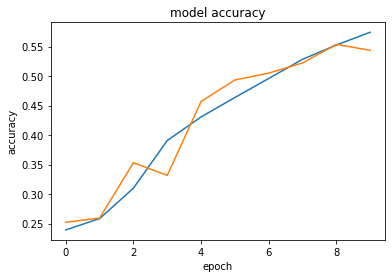

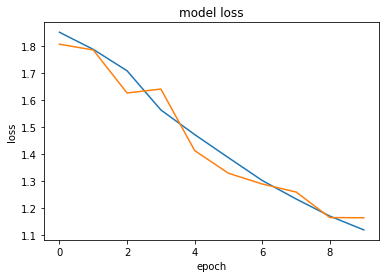

In [309]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [366]:
model.save('model.h5')

In [459]:
prediction = model.predict(testing_inputs)

2022-05-05 15:37:35.955734: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [311]:
prediction_category = [np.argmax(prediction[i]) for i in range(len(testing_label))]

In [320]:
testing_category = [list(testing_label[i].numpy()).index(1.0) for i in range(len(testing_label))]

In [328]:
testing = np.mean(np.array(prediction_category) == np.array(testing_category))

In [340]:
testing

0.5483421565895793

In [410]:
prediction

array([[6.0216426e-03, 9.3801536e-05, 8.7163178e-03, 7.7001381e-01,
        7.7709719e-03, 1.5339393e-02, 1.9204406e-01]], dtype=float32)

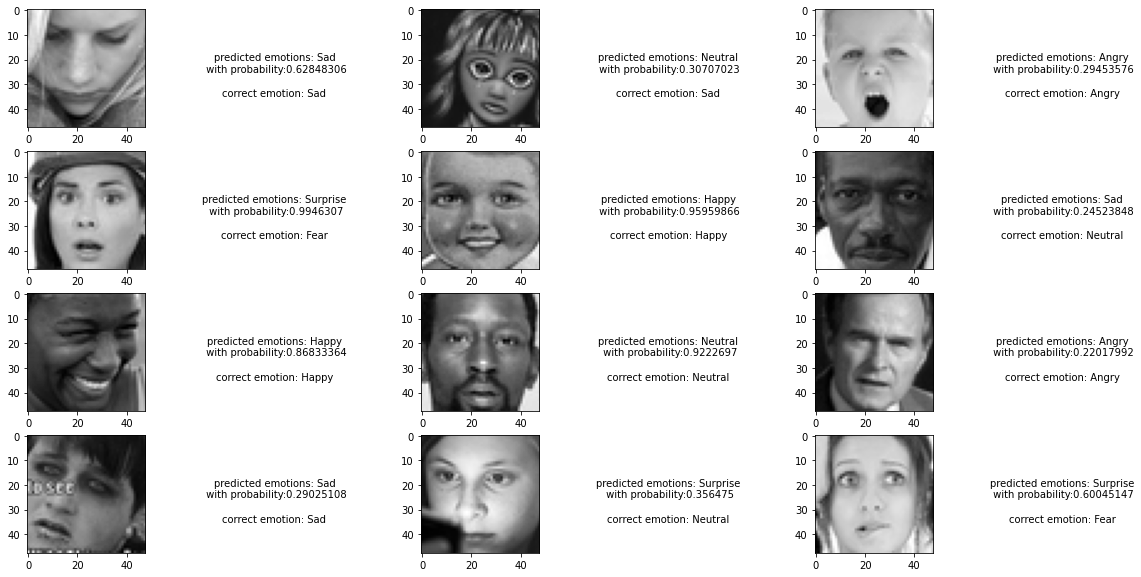

In [455]:
plt.figure(0, figsize=(20,10))
for i in range(26, 38):
    plt.subplot(4,3,i-25)
    plt.imshow(testing_inputs[i, :, :, 0], cmap="gray")
    plt.text(100, 25, "predicted emotions: " + emotions_dict[prediction_category[i]] + "\n with probability:" + str(max(prediction[i])), ha = "center")
    plt.text(100, 35, "correct emotion: " + emotions_dict[list(testing_label[i].numpy()).index(1.0)], ha = "center")
    

In [345]:
print(classification_report(testing_category, prediction_category))

              precision    recall  f1-score   support

           0       0.55      0.36      0.44       934
           1       0.39      0.28      0.32       112
           2       0.36      0.21      0.27       992
           3       0.73      0.83      0.78      1790
           4       0.48      0.34      0.39      1306
           5       0.55      0.84      0.66       830
           6       0.44      0.62      0.51      1214

    accuracy                           0.55      7178
   macro avg       0.50      0.49      0.48      7178
weighted avg       0.54      0.55      0.53      7178



Text(114.0, 0.5, 'True Category')

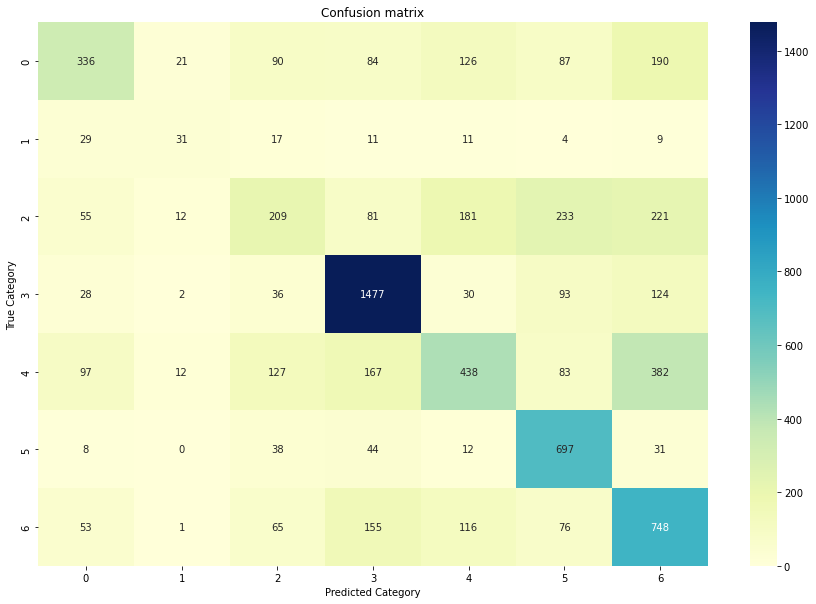

In [358]:
cm = tf.math.confusion_matrix(labels = testing_category, predictions = prediction_category)
plt.figure(figsize = (15, 10))
sn.heatmap(cm, annot = True, fmt = 'd', cmap="YlGnBu")
plt.title("Confusion matrix")
plt.xlabel('Predicted Category')
plt.ylabel('True Category')

### Emoji
#### (Note: This part applies Apple Emoji Conversion with photos provided by Ying Sun)

In [477]:
def emoji_convertion_demo(i):
    predicted_category = prediction_category[i]
    emotion_dict = emotions_dict
    for j in range(7):
        if predicted_category == j:
            img = image.imread("emoji_ying/" + emotion_dict[predicted_category]+".JPG")
    plt.figure();
    f, axarr = plt.subplots(1,2);
    plt.subplots_adjust(left=0.0,
                        bottom=0.0, 
                        right=1.0, 
                        top=1.0, 
                        wspace=0.6, 
                        hspace=0.6);
    # use the created array to output your multiple images. In this case I have stacked 4 images vertically
    axarr[0].imshow(testing_inputs[i, :, :, 0], cmap="gray");
    #plt.text(-150, 25, "predicted emotions: " + emotions_dict[prediction_category[100]], ha = "center")
    axarr[1].imshow(img);
    plt.text(100, -10, "predicted emotions: " + emotions_dict[prediction_category[i]] + "\n with probability:" + str(max(prediction[i])), ha = "center");
    plt.text(-235, 20, "correct emotion: " + emotions_dict[list(testing_label[i].numpy()).index(1.0)], ha = "center");

<Figure size 432x288 with 0 Axes>

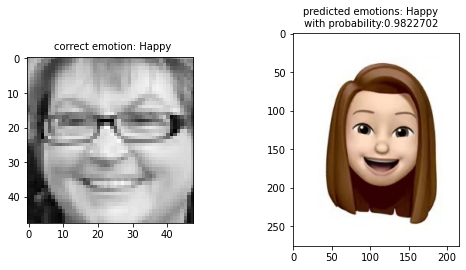

In [480]:
emoji_convertion_demo(100)

<Figure size 432x288 with 0 Axes>

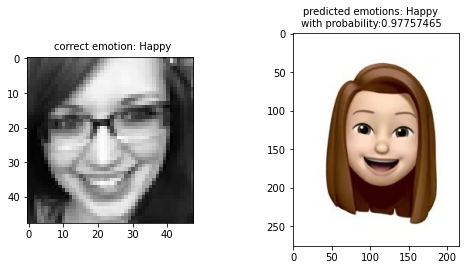

In [488]:
emoji_convertion_demo(4)

<Figure size 432x288 with 0 Axes>

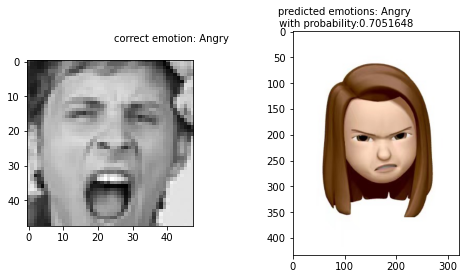

In [490]:
emoji_convertion_demo(11)

<Figure size 432x288 with 0 Axes>

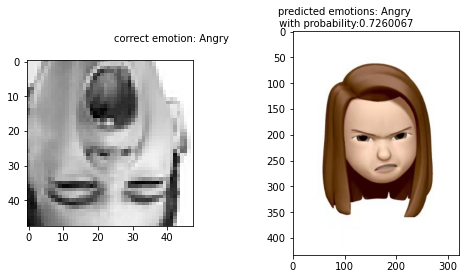

In [494]:
emoji_convertion_demo(5000)

<Figure size 432x288 with 0 Axes>

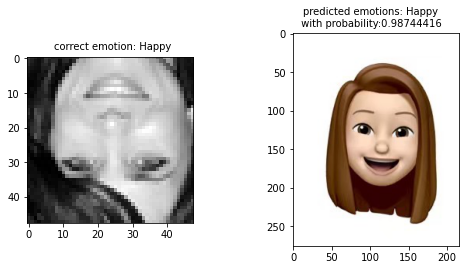

In [498]:
emoji_convertion_demo(5700)

<Figure size 432x288 with 0 Axes>

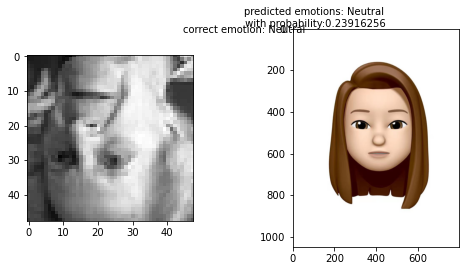

In [504]:
emoji_convertion_demo(6900)

### Part 3. Web Camera
#### (Note: the webcamera technology is modified based on https://github.com/NJNischal/Facial-Expression-Recognition-with-CNNs/blob/master/camera.py)

In [456]:
model = tf.keras.models.load_model('model.h5')
emotion_dict = emotions_dict
cap = cv2.VideoCapture(0)
while True:
    ret, frame = cap.read()
    if not ret:
        break
    facecasc = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = facecasc.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=5)

    for (x, y, w, h) in faces:
        cv2.rectangle(frame, (x, y-50), (x+w, y+h+10), (255, 0, 0), 2)
        roi_gray = gray[y:y + h, x:x + w]
        cropped_img = np.expand_dims(np.expand_dims(cv2.resize(roi_gray, (48, 48)), -1), 0)
        prediction = model.predict(cropped_img)
        maxindex = int(np.argmax(prediction))
        cv2.putText(frame, emotion_dict[maxindex], (x+20, y-60), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

    cv2.imshow('Video', cv2.resize(frame,(1600,960),interpolation = cv2.INTER_CUBIC))
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
        
cap.release()
cv2.destroyAllWindows()

2022-05-05 15:36:15.185870: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [368]:
cap.release()
cv2.destroyAllWindows()